# 2D potential toy model: Mueller potential

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from boltzmann_generator import BoltzmannGenerator
from analysis import *
import energy_models.toy_2d_potentials as toy_2d_potentials
MuellerPotential = toy_2d_potentials.MuellerPotential

In [5]:
params = MuellerPotential.default_params.copy()
params['alpha'] = 0.1
mueller = MuellerPotential(params=params)

## Auxiliary scripts

In [6]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4), orientation='vertical'):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.9, 6.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xticks([-1, 0, 1])
        plt.yticks([0, 1, 2])
    else:
        plt.xticks([])
        plt.yticks([])
    return cbar

In [7]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    z_path = z1 + lambdas*(z2-z1)
    x_path = bg.transform_zx(z_path)
    return x_path

In [8]:
def find_low_energy_transitions(bg, n_output=5, n_trial=30):
    x_paths = []
    max_energies_in_paths = []
    for i in range(n_trial):
        x1 = traj_left[np.random.randint(100)] 
        x2 = traj_right[np.random.randint(100)]
        x_path = latent_interpolation(bg, x1, x2, nstep=1000)
        x_paths.append(x_path)
        max_energies_in_paths.append(np.nanmax(mueller.energy(x_path)))
    
    # Calculate maximal energy in each path
    max_energies_in_paths = np.array(max_energies_in_paths)
    # Determine indices of paths with lowest E_max
    indices = np.argpartition(max_energies_in_paths, n_output)
    lowest_energy_x_paths = []
    for ix in indices[:n_output]:
        lowest_energy_x_paths.append(x_paths[ix])
        
    return lowest_energy_x_paths

## Landscape of potential

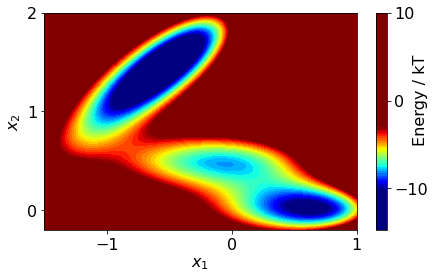

In [9]:
plot_potential(labels=True, cbar=True)

## Produce training dataset by MC simulation

- Ensure that trajectory of MC simulation for right metastable state (red) does not get to area of intermediate (orange) configurations, which should be not seen by BG during training. If these occurs, rerun the MC simulation. 

In [10]:
from sampling import MetropolisGauss

In [14]:
nsteps = 1000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, sigma_metro=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.trajectory.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.trajectory.copy()

In [15]:
x_intermediate = np.array([[-0.05, 0.45]]) + np.array([[0.15, 0.05]]) * np.random.randn(100, 2)

Blue and red configurations are used for training. Orange configurations are used only in validation as a clue.

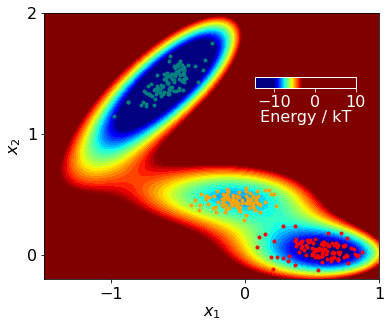

In [16]:
cbar = plot_potential(labels=True, cbar=True, figsize=(6, 7), orientation='horizontal')
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
plt.plot(x_intermediate[:, 0], x_intermediate[:, 1], color='orange', linewidth=0, marker='.')

In [17]:
training_dataset = np.vstack([traj_left, traj_right])
validation_dataset = np.vstack([traj_left_val, traj_right_val])

## Define BG parameters
- 5 Real NVP layers are used.
- Each S or T transformation inside Real NVP has 3 hidden layers with 100 units each.
- $y$ ($x_2$) is used as a RC

In [18]:
bg_params = {
    "layers": 'R' * 5, 
    "energy_model": mueller,
    "nl_layers": 3
}

In [19]:
def get_y(x):
    return x[:, 1]

rc_loss_params = {
    "rc_function": get_y,
    "rc_min": -0.1,
    "rc_max": 1.7,
}

## Training and valiation scripts

In [20]:
def train_bg(bg, training_schedule):
    for args in training_shedule:
        input("Can I continue in training? (press Enter)")
        current_loss_vals = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            print_total_loss_only = True,
            print_training_info_interval=20,
            **rc_loss_params
        )
    
        for loss_name in ["loss", "val_loss"]:
            plt.plot(current_loss_vals[loss_name], label=loss_name)

        plt.legend(loc='upper right')
        plt.show()

In [21]:
proj_dir = np.array([[0.7],[-0.7]])

def validate_bg(bg):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    plt.subplots_adjust(hspace=0.25, wspace=0.25)
    
    # Sample from BG
    sample_z, sample_x, sample_Ez, sample_Ex, sample_logw = bg.sample(100000)
    proj = sample_x.dot(proj_dir)
    
    # 1.) 2D potential and X samples
    axis = axes[0][0]
    axis.set_title("Samples in X")
    # Plot potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    axis.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    axis.set_xticks([])
    axis.set_yticks([])
    # Plot samples in Z
    axis.plot(sample_x[::10, 0], sample_x[::10, 1], color='white', linewidth=0, marker='.', markersize=2)
    axis.set_xlim(-1.5, 1.0)
    axis.set_ylim(-0.2, 2.0)
    
    # 2.) Plot z distribution
    axis = axes[0][1]
    axis.set_title("Z distribution")
    z_left = bg.transform_xz(traj_left)
    z_int = bg.transform_xz(x_intermediate)
    z_right = bg.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=6, color='blue')
    axis.plot(z_int[:, 0], z_int[:, 1], linewidth=0, marker='.', markersize=6, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=6, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$')
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    
    # 3.) Free-energy profile
    axis = axes[1][0]
    axis.set_title("Free-energy profile")
    
    # Option 1: Single calculation and using weight cutoff to prevent unreliable predictions
#     # Create weighted histogram of distribution along projection (unnormalized)
#     hist, bin_edges = np.histogram(proj[:, 0], bins=100, weights=np.exp(sample_logw-sample_logw.max()))
#     bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
#     # Eliminate low-weight samples
#     hist = np.where(hist < 0.005, np.nan, hist)
#     F_calc = -np.log(hist)
#     F_calc_error = None
    
    # Option 2: Use bootstrap to calculate mean and error
    bin_values, Fs = free_energy_bootstrap(proj[:, 0], 100, (-2, 1), log_weights=sample_logw)
    F_calc = mean_finite(Fs, axis=0)
    F_calc_error = std_finite(Fs, axis=0)
    # Eliminate free-energy predictions with error greater than cutoff
    error_cutoff = 0.6
    F_calc = np.where(F_calc_error > error_cutoff, np.nan, F_calc)
    F_calc_error = np.where(F_calc_error > error_cutoff, np.nan, F_calc_error)
     
    # Create histogram from reference Monte Carlo simulation
    hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
    bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])
    
    # Calculate free-energy profile
    F_ref = -np.log(hist_ref)
    F_calc_shifted = F_calc - np.nanmin(F_calc) + np.nanmin(F_ref)
    
    # Plot calculated and reference free-energy profiles
    axis.plot(bin_values_ref, F_ref, color='black', linewidth=4)
    axis.errorbar(bin_values, F_calc_shifted, F_calc_error, color='orange', linewidth=2)
    axis.set_xlim(-2, 1)
    axis.set_ylim(-10, 6)
    axis.set_yticks([-10, -5, 0, 5])
    axis.set_xlabel('$x_{proj}$')
    axis.set_ylabel('Free energy / kT', labelpad=-10)
    
    # 4.) Low energy transitions
    axis = axes[1][1]
    axis.set_title("Low-energy transitions")
    
    lowest_energy_x_paths = find_low_energy_transitions(bg)
    
    # Plot potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    axis.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    
    axis.set_xticks([])
    axis.set_xlabel('')
    axis.set_yticks([])
    axis.set_ylabel('')
    for x_path in lowest_energy_x_paths:
        axis.plot(x_path[:, 0], x_path[:, 1], linewidth=2, color='white')

## Calculate reference free energy profile
- 10^6 samples reweighted with Boltzmann factor are used

In [22]:
# Reference free energy calculation:
xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
xwild_ener = mueller.energy(xwild)
xwild_w = np.exp(-(xwild_ener-xwild_ener.min()))
xwild_proj = xwild.dot(proj_dir)

## Train and validate Boltzmann generators
- First BG is trained without using RC. Second one uses also RC-entropy loss during training.
- Training dataset in $x$ contains 200 samples.

For each BG, there are 4 figures used for validation:
- Distribution of produced samples (white dots) with potential landscape in background
- Position of $x$ training samples in latent space.
- Calculated free energy profile compared to reference calculation.
- Linear latent interpolation between samples from training dataset.

### BG training without using RC

In [23]:
bg_without_RC = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [24]:
                # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,  0,  0,   200,  500,  1e-3],
                    [1,  1,  0,   400,  1000, 1e-3]]

Can I continue in training? (press Enter)
Iteration 0/200: loss: 0.5962 val_loss: 0.4870 
Iteration 20/200: loss: -0.8941 val_loss: -0.8871 
Iteration 40/200: loss: -1.6650 val_loss: -1.7065 
Iteration 60/200: loss: -2.3187 val_loss: -2.3258 
Iteration 80/200: loss: -2.5423 val_loss: -2.6772 
Iteration 100/200: loss: -2.7467 val_loss: -2.8272 
Iteration 120/200: loss: -2.8204 val_loss: -2.7423 
Iteration 140/200: loss: -2.9457 val_loss: -2.9338 
Iteration 160/200: loss: -3.0094 val_loss: -2.9520 
Iteration 180/200: loss: -2.8726 val_loss: -2.9898 


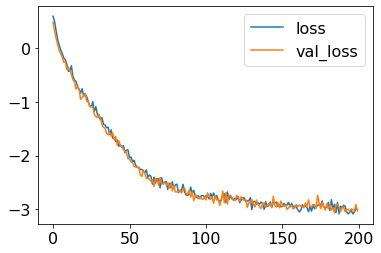

Can I continue in training? (press Enter)
Iteration 0/400: loss: -10.2144 val_loss: 6.1418 
Iteration 20/400: loss: -9.9395 val_loss: -9.9928 
Iteration 40/400: loss: -10.3373 val_loss: -10.3931 
Iteration 60/400: loss: -10.6278 val_loss: -10.7016 
Iteration 80/400: loss: -10.8868 val_loss: -11.0322 
Iteration 100/400: loss: -10.9070 val_loss: -11.0473 
Iteration 120/400: loss: -10.9841 val_loss: -10.8260 
Iteration 140/400: loss: -11.1706 val_loss: -11.3519 
Iteration 160/400: loss: -11.2803 val_loss: -11.1444 
Iteration 180/400: loss: -11.1931 val_loss: -11.2345 
Iteration 200/400: loss: -11.3443 val_loss: -11.2445 
Iteration 220/400: loss: -11.3052 val_loss: -11.3467 
Iteration 240/400: loss: -11.2593 val_loss: -11.1561 
Iteration 260/400: loss: -11.2796 val_loss: -11.1809 
Iteration 280/400: loss: -11.3213 val_loss: -11.2218 
Iteration 300/400: loss: -11.5401 val_loss: -11.4355 
Iteration 320/400: loss: -11.1255 val_loss: -11.3272 
Iteration 340/400: loss: -11.2721 val_loss: -11.39

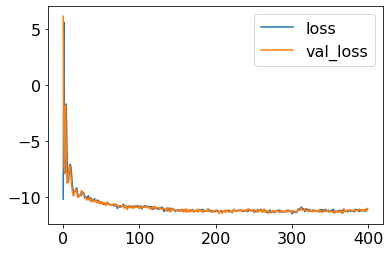

In [25]:
train_bg(bg_without_RC, training_shedule)

../analysis.py:114: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)
<ipython-input-21-fc5a05788192>:70: RuntimeWarning: invalid value encountered in greater
  F_calc = np.where(F_calc_error > error_cutoff, np.nan, F_calc)
<ipython-input-21-fc5a05788192>:71: RuntimeWarning: invalid value encountered in greater
  F_calc_error = np.where(F_calc_error > error_cutoff, np.nan, F_calc_error)


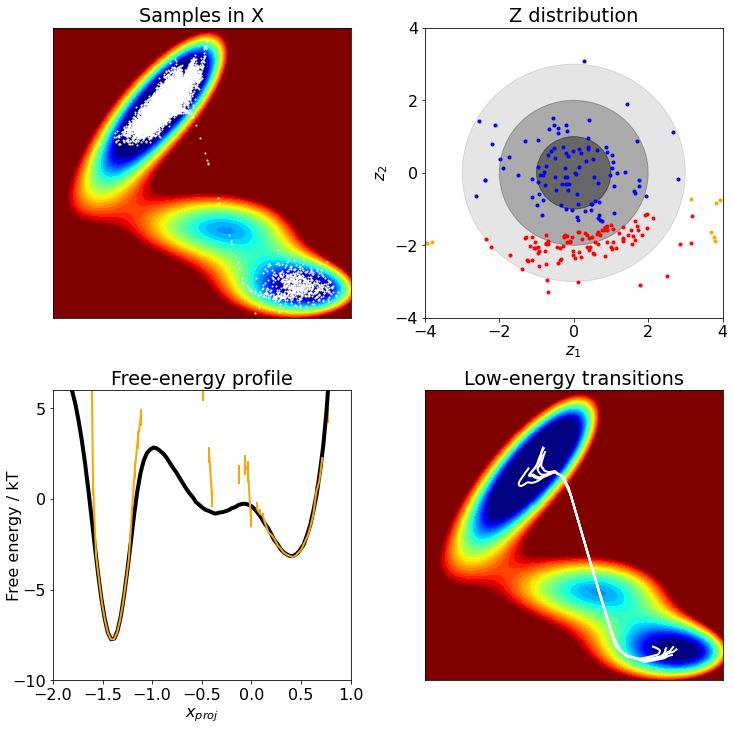

In [26]:
validate_bg(bg_without_RC)

### BG training using RC

In [58]:
bg_with_RC = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [59]:
                # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,    0,  0,   200,  500,  1e-3],
                    [1,    1,  1,   300,  1000, 1e-3],
                    [0.01, 1,  3,   200,  1000, 1e-3]]

Can I continue in training? (press Enter)
Iteration 0/200: loss: 0.5413 val_loss: 0.4051 
Iteration 20/200: loss: -0.8556 val_loss: -0.9688 
Iteration 40/200: loss: -1.9364 val_loss: -2.0356 
Iteration 60/200: loss: -2.6186 val_loss: -2.3679 
Iteration 80/200: loss: -2.8976 val_loss: -2.7874 
Iteration 100/200: loss: -2.8474 val_loss: -2.9102 
Iteration 120/200: loss: -2.9485 val_loss: -2.9660 
Iteration 140/200: loss: -2.9119 val_loss: -3.0029 
Iteration 160/200: loss: -2.9512 val_loss: -2.8819 
Iteration 180/200: loss: -2.9853 val_loss: -2.9465 


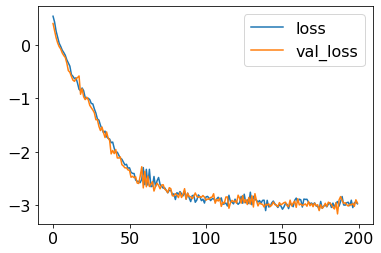

Can I continue in training? (press Enter)
Iteration 0/300: loss: -12.5420 val_loss: -8.6564 
Iteration 20/300: loss: -12.3661 val_loss: -12.5318 
Iteration 40/300: loss: -12.9569 val_loss: -12.9481 
Iteration 60/300: loss: -12.8920 val_loss: -12.8697 
Iteration 80/300: loss: -13.0930 val_loss: -13.0538 
Iteration 100/300: loss: -12.9216 val_loss: -13.1200 
Iteration 120/300: loss: -13.1372 val_loss: -13.2205 
Iteration 140/300: loss: -13.1363 val_loss: -13.2163 
Iteration 160/300: loss: -13.0708 val_loss: -13.2351 
Iteration 180/300: loss: -13.0112 val_loss: -13.0444 
Iteration 200/300: loss: -13.0364 val_loss: -13.0796 
Iteration 220/300: loss: -13.1852 val_loss: -13.2042 
Iteration 240/300: loss: -13.2240 val_loss: -13.2969 
Iteration 260/300: loss: -13.2778 val_loss: -13.1788 
Iteration 280/300: loss: -13.2379 val_loss: -13.3072 


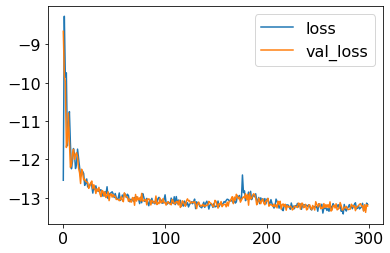

Can I continue in training? (press Enter)
Iteration 0/200: loss: -14.2743 val_loss: -13.7338 
Iteration 20/200: loss: -14.5006 val_loss: -14.5064 
Iteration 40/200: loss: -14.5811 val_loss: -14.6527 
Iteration 60/200: loss: -14.6657 val_loss: -14.5623 
Iteration 80/200: loss: -14.7299 val_loss: -14.6894 
Iteration 100/200: loss: -14.7607 val_loss: -14.7186 
Iteration 120/200: loss: -14.8106 val_loss: -14.6311 
Iteration 140/200: loss: -14.6777 val_loss: -14.7526 
Iteration 160/200: loss: -14.7585 val_loss: -14.7315 
Iteration 180/200: loss: -14.7138 val_loss: -14.7947 


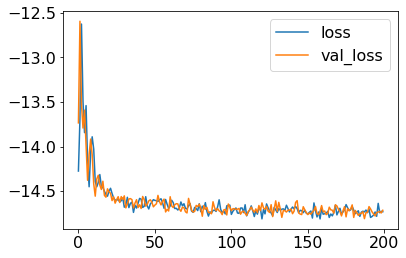

In [60]:
train_bg(bg_with_RC, training_shedule)

../analysis.py:114: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)
<ipython-input-21-fc5a05788192>:70: RuntimeWarning: invalid value encountered in greater
  F_calc = np.where(F_calc_error > error_cutoff, np.nan, F_calc)
<ipython-input-21-fc5a05788192>:71: RuntimeWarning: invalid value encountered in greater
  F_calc_error = np.where(F_calc_error > error_cutoff, np.nan, F_calc_error)


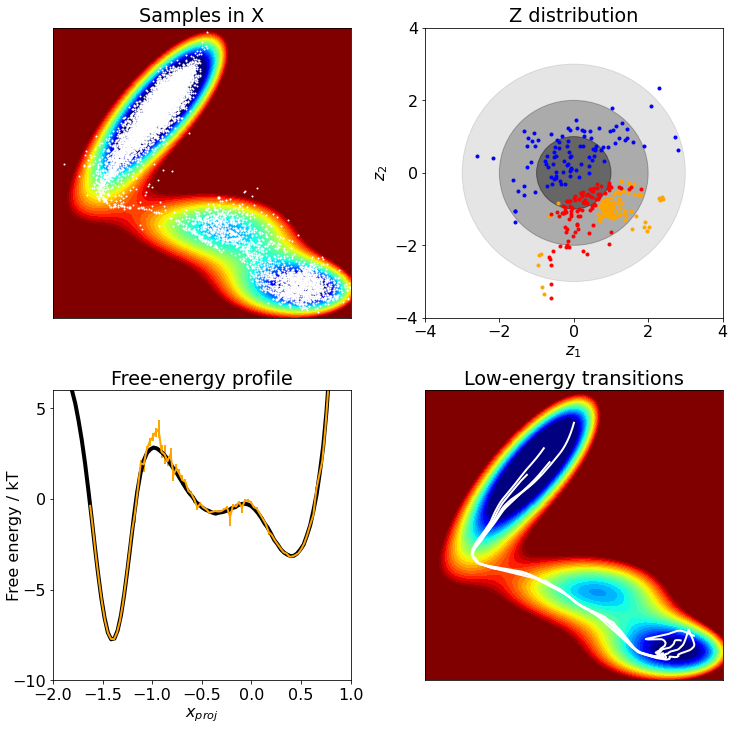

In [61]:
validate_bg(bg_with_RC)